In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import caffe
import itertools as it
import pandas
import cv2
import scipy

from collections import defaultdict
from math import ceil
from copy import copy
from collections import OrderedDict
from operator import itemgetter, attrgetter
from matplotlib import pyplot
from scipy import ndimage as ndimage
from wurlitzer import pipes
from os.path import join as pjoin

from caffe import layers as L
from caffe import params as P
import tools

from ntb.layer.data import Transformer
from ntb.db import *

%matplotlib inline
pyplot.rcParams['figure.figsize'] = (10, 6)

In [2]:
SUB_DIR = "ft_sigmoid_noaug_rmportraits_sgd"

In [3]:
db = NTBDB()

# Data preparation

In [5]:
label_to_ntb = {
    'football': ['footbal', 'football-pitches', 'fotballs'],
    'person': ['full-length-portrait', 'portrait', 'persons'],
    'skiing': [
        'skiing', 'alpine-skiing', 'nordic-skiing', 'biathlon', 'freeskiing', 'freestyle-skiing', 'slalom', 'snowboarding', 'giant-slalom',
        'super-g', 'telemark-skiiing', 'downhill-skiing', 'nordic-combined', 'cross-country-skiing', 'ski-jumping', 'ski-orienteering',
        'long-distance-ski-races', 'ski-flying', 'relay-races', 'skis-and-ski-poles', 'ski-trips',
    ],
    'team-handball': ['team-handball'],
    'woman': ['women'],
    'child': ['children', 'girls', 'boys'],
    'skating': ['icehockey', 'skating', 'figure-skating'],
    'flag': ['flags'],
    'crowd': ['demonstrations', 'supporters', 'crowds'],
    'car': ['cars', 'ambulances', 'electric-cars', 'hybrid-cars', 'limousines', 'sports-cars', 'classic-cars', 'police-cars', 'automobile-racing', 'traffic'],
    'bicycling': ['bicycle-racing', 'bicycling', 'road-bicycle-racing', 'bicycles', 'cross-country-bicycling'],
    'flower': ['flowers', 'bouquet-of-flowers'],
    'man': ['men'],
    'medal': ['medals'],
    'snow': ['snow'],
    'hand': ['hands'],
    'triumph': ['sign-of-triumph'],
    'army': ['soldiers', 'the-armed-forces'],
    'boat': ['boats', 'yachting', 'ferries', 'sailboats', 'passenger-ships', 'cruise-ships', 'fishing-boats'],
    'norwegian-national-costumes': ['norwegian-national-costumes'],
    'landscape': ['landscape'],
    'signs': ['signs', 'traffic-signs'],
    'running': ['running-[athletics]', 'middle-distance-running', 'long-distance-running'],
    'aeroplane': ['aeroplanes'],
    'sky': ['sky', 'clouds'],
    'firemen': ['firemen'],
    'beach-volleyball': ['beach-volleyball'],
    'train': ['trains'],
    'umbrella': ['umbrellas'],
    'swimming': ['swimming-[sports]', 'swimming'],
    'dog': ['dogs'],
    'bus': ['buses'],
    'harbour': ['harbours'],
    'park': ['parks', 'forests'],
    'bridge': ['bridges'],
    'tree': ['trees'],
    'shoe': ['shoes'],
    'beach': ['beaches'],
    'helicopter': ['helicopters', 'rescue-helicopters'],
#     'red-carpet': ['red-carpet'],
#     'horse': ['horses'],
}
labels = np.asarray(sorted(label_to_ntb.keys()))
assert len(list(it.chain.from_iterable(label_to_ntb.values()))) == len(set(it.chain.from_iterable(label_to_ntb.values()))), "Dublicates"

In [14]:
ntb_to_label = {ntb_label: label for label, ntb_labels in label_to_ntb.items() for ntb_label in ntb_labels}

dataset = {
    label: set(it.chain.from_iterable(
        map(itemgetter('filename'), db.by_tag[ntb_label]) for ntb_label in ntb_labels
    )) for label, ntb_labels in label_to_ntb.items()
}

### Filtering out portrait pictures:

In [64]:
portrait_tags = {'portrait', u'press-conferences', u'coaches'}
include_portrait = {'child', 'hand', 'man', 'woman', 'triumph', 'umbrella', 'person', 'norwegian-national-costumes', 'medal'}
exclude_portrait = set(labels) - include_portrait
portrait_pics = set(map(itemgetter('filename'), it.chain.from_iterable(db.by_tag[pt] for pt in portrait_tags)))

In [ ]:
excluded_df = {}
for label in dataset:
    if label not in exclude_portrait:
        excluded_df[label] = "-"
        continue
    before = dataset[label]
    after = before - portrait_pics
    dataset[label] = after
    rate = float(len(before) - len(after))/ len(before)
    excluded_df[label] = round(rate * 100, 2)

excluded_df = pandas.DataFrame.from_dict(excluded_df, orient='index').rename(index=str, columns={0: 'excluded %'})

In [56]:
excluded_df.sort_values('excluded %', ascending=False)

,excluded %
umbrella,-
norwegian-national-costumes,-
triumph,-
person,-
man,-
medal,-
child,-
hand,-
woman,-
team-handball,22.94


### Labels distribution

In [58]:
def plot_distribution(data):
    pic_num_distribution = {
        label: len(imgs) for label, imgs in data.items()
    }
    data = sorted(pic_num_distribution.items(), key=itemgetter(1), reverse=True)
    df = pandas.DataFrame.from_dict(OrderedDict(data), orient='index')
    df.plot(kind='bar', legend=False)

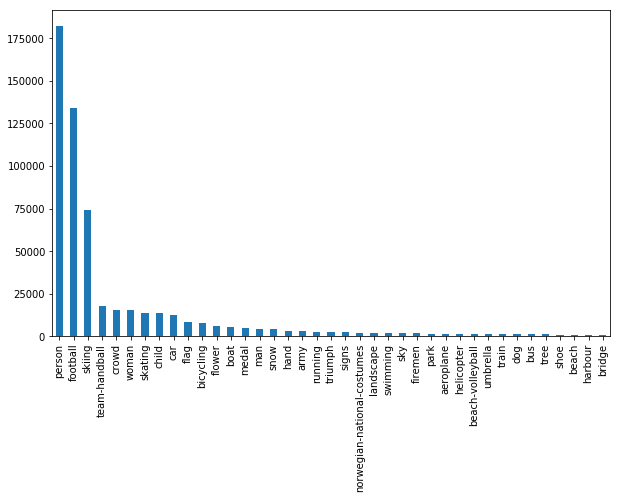

In [59]:
plot_distribution(dataset)

### Reducing imblalance

In [65]:
def balance_dataset(dataset, limit=10000):
    img_pools = {label: list(imgs) for label, imgs in dataset.items()}
    balanced = defaultdict(set)
    # shuffle img_pools
    for imgs in img_pools.values():
            random.shuffle(imgs)
    
    def insert_image(img):
        for label, imgs in dataset.iteritems():
            if img in imgs:
                balanced[label].add(img)
    
    # process categories below the limit first
    for label, pool in img_pools.iteritems():
        if len(pool) > limit:
            continue
        while pool:
            img = pool.pop()
            insert_image(img)

    to_process = set(dataset.keys())
    while to_process:
        for label in to_process.copy():
            pool = img_pools[label]
            if not pool or len(balanced[label]) >= limit:
                # finished with this label
                to_process.discard(label)
                continue
            img = random.choice(pool)
            insert_image(img)
    return dict(balanced)

dataset_balanced = balance_dataset(dataset)
assert all(
    len(imgs - dataset[label]) == 0
    for label, imgs in dataset_balanced.items()
), "Some images are not in the right categories"
assert all(
    (label in exclude_portrait and img in portrait_pics) or img in dataset_balanced[label]
    for img in it.chain.from_iterable(dataset_balanced.values())
    for label in filter(None, map(lambda nl: ntb_to_label.get(nl, None), db.metadata[img]['tags']))
), "Check that image is in all categories"

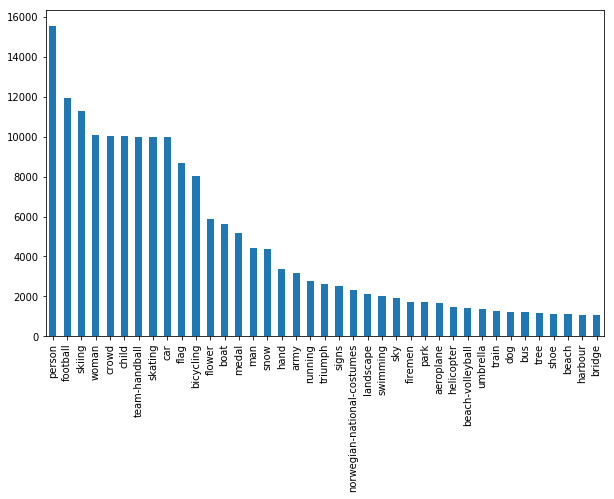

In [66]:
plot_distribution(dataset_balanced)

### Train/Validation/Test dataset split on per category basis

In [67]:
def split_dataset(dataset, ratio):
    img_pools = {label: list(imgs) for label, imgs in dataset.items()}
    split = defaultdict(set)
    # shuffle img_pools
    for imgs in img_pools.values():
            random.shuffle(imgs)
    
    def insert_image(img):
        for label, imgs in dataset.iteritems():
            if img in imgs:
                split[label].add(img)
    
    to_process = set(dataset.keys())
    while to_process:
        for label in to_process.copy():
            pool = img_pools[label]
            if not pool or float(len(split[label])) / len(dataset[label]) >= ratio:
                # finished with this label
                #print label, len(pool), len(balanced[label])
                to_process.discard(label)
                continue
            img = pool.pop()
            insert_image(img)
    return dict(split), {label: imgs - split[label] for label, imgs in dataset.iteritems()}

In [68]:
train, rest = split_dataset(dataset_balanced, 0.6)
val, test = split_dataset(rest, 0.5)
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(test.values())))
assert not set(it.chain.from_iterable(train.values())).intersection(set(it.chain.from_iterable(val.values())))
assert not set(it.chain.from_iterable(val.values())).intersection(set(it.chain.from_iterable(test.values())))

### Write sampled dataset to sub directory

In [69]:
data_dir = pjoin(BASE_DIR, 'nets', SUB_DIR, 'data')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

def dump_training_data(data, split):
    training_data = {}
    for label, imgs in data.iteritems():
        for index in imgs:
            training_data.setdefault(index, {})
            if 'folder' not in training_data[index]:
                training_data[index]['folder'] = db.metadata[index]['folder']
            training_data[index].setdefault('labels', []).append(labels.tolist().index(label))
    data_path = pjoin(data_dir, split + '.pickle')
    with open(data_path, mode='w') as f:
        pickle.dump(training_data, f, protocol=pickle.HIGHEST_PROTOCOL)

In [70]:
dump_training_data(train, 'train')
dump_training_data(val, 'val')

In [71]:
with open(pjoin(data_dir, 'train_raw.pickle'), mode='w') as f:
    pickle.dump(train, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'val_raw.pickle'), mode='w') as f:
    pickle.dump(val, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'test_raw.pickle'), mode='w') as f:
    pickle.dump(test, f, protocol=pickle.HIGHEST_PROTOCOL)
with open(pjoin(data_dir, 'labels.np'), mode='w') as f:
    labels.dump(f)

# Training

In [72]:
caffe.set_mode_gpu()

### Define network

In [163]:
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

def add_caffenet(net):
    net.conv1, net.relu1 = conv_relu(net.data, 11, 96, stride=4)
    net.pool1 = max_pool(net.relu1, 3, stride=2)
    net.norm1 = L.LRN(net.pool1, local_size=5, alpha=1e-4, beta=0.75)
    net.conv2, net.relu2 = conv_relu(net.norm1, 5, 256, pad=2, group=2)
    net.pool2 = max_pool(net.relu2, 3, stride=2)
    net.norm2 = L.LRN(net.pool2, local_size=5, alpha=1e-4, beta=0.75)
    net.conv3, net.relu3 = conv_relu(net.norm2, 3, 384, pad=1)
    net.conv4, net.relu4 = conv_relu(net.relu3, 3, 384, pad=1, group=2)
    net.conv5, net.relu5 = conv_relu(net.relu4, 3, 256, pad=1, group=2)
    net.pool5 = max_pool(net.relu5, 3, stride=2)
    net.fc6, net.relu6 = fc_relu(net.pool5, 4096)
    net.drop6 = L.Dropout(net.relu6, in_place=True)
    net.fc7, net.relu7 = fc_relu(net.drop6, 4096)
    net.drop7 = L.Dropout(net.relu7, in_place=True)
    net.score = L.InnerProduct(net.drop7, num_output=labels.size)
    return net

def caffenet_multilabel_train(data_layer_params):
    # setup the ntb data layer 
    net = caffe.NetSpec()
    net.data, net.label = L.Python(
        module='ntb.layer.data', layer='NTBDataLayer', 
        ntop=2, param_str=str(data_layer_params)
    )

    net = add_caffenet(net)
    
    # Changed loss function
    net.loss = L.SigmoidCrossEntropyLoss(net.score, net.label)
    
    name_field = 'name: "{}"'.format(SUB_DIR)
    return name_field + '\n' + str(net.to_proto())

def caffenet_multilabel_test(batch_size):
    # setup the ntb data layer 
    net = caffe.NetSpec()
    net.data = L.Input(input_param={"shape": {"dim": [batch_size, 3, 227, 227]}})

    net = add_caffenet(net)
    
    # Changed loss function
    net.prob = L.Sigmoid(net.fc7)
    
    name_field = 'name: "{}"'.format(SUB_DIR)
    return name_field + '\n' + str(net.to_proto())

### Write nets and solver files

In [164]:
workdir = pjoin('/storage/ntb/nets', SUB_DIR)
if not os.path.isdir(workdir):
    os.makedirs(workdir)
snapshotsdir = os.path.join(workdir, 'snapshots')
if not os.path.isdir(snapshotsdir):
    os.makedirs(snapshotsdir)

logs_file_path = pjoin(workdir, 'train.log')
    
solverprototxt = tools.CaffeSolver(
    trainnet_prototxt_path=os.path.join(workdir, "trainnet.prototxt"),
    testnet_prototxt_path=os.path.join(workdir, "valnet.prototxt"),
)
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.sp['display'] = "1"
solverprototxt.sp['snapshot'] = "200"
solverprototxt.sp['lr_policy'] = '"fixed"'
solverprototxt.sp['test_interval'] = "200"
solverprototxt.sp['test_iter'] = "1000"
solverprototxt.sp['max_iter'] = "1000"
# solverprototxt.sp['power'] = "0.5"
solverprototxt.sp['snapshot_prefix'] = '"{}"'.format(os.path.join(snapshotsdir, 'snapshot'))
solverprototxt.write(os.path.join(workdir, 'solver.prototxt'))

base_data_layer_params = dict(
    batch_size=200,
    im_shape=[227, 227],
    ntb_root=BASE_DIR,
    sub_dir=SUB_DIR,
    num_labels=labels.size
)
# write train net.
with open(os.path.join(workdir, 'trainnet.prototxt'), 'w') as f:
    data_layer_params = dict(base_data_layer_params, split='train')
    f.write(caffenet_multilabel_train(data_layer_params))

# write validation net.
with open(os.path.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(base_data_layer_params, split='val', batch_size=20)
    f.write(caffenet_multilabel_train(data_layer_params))
    
# write testing net.
with open(os.path.join(workdir, 'testnet.prototxt'), 'w') as f:
    f.write(caffenet_multilabel_test(256))

### Load solver

In [115]:
solver = caffe.SGDSolver(os.path.join(workdir, 'solver.prototxt'))

BatchLoader initialized with 75131 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug_rmportraits_sgd, split: train, with bs: 200, im_shape: [227, 227], num_labels: 39.
BatchLoader initialized with 26225 images
NTBDataLayer initialized for sub_dir: ft_sigmoid_noaug_rmportraits_sgd, split: val, with bs: 20, im_shape: [227, 227], num_labels: 39.


### Start new training

In [116]:
try:
    os.remove(logs_file_path)
except:
    pass
solver.net.copy_from('/models/caffenet/bvlc_reference_caffenet.caffemodel')
solver.test_nets[0].share_with(solver.net)

### Restore from snapshot

In [20]:
for snapshot in sorted(os.listdir(snapshotsdir)):
    if snapshot.endswith('solverstate'):
        print snapshot

snapshot_iter_101.solverstate
snapshot_iter_200.solverstate
snapshot_iter_853.solverstate


In [21]:
solver.restore(os.path.join(snapshotsdir, 'snapshot_iter_200.solverstate'))
solver.test_nets[0].share_with(solver.net)

### Check images and labels

In [118]:
# transformer = Transformer(shape=[227, 227])
# image_index = 1
# pyplot.figure()
# pyplot.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
# gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
# pyplot.title('GT: {}'.format(labels[np.where(gtlist)]))
# pyplot.axis('off');

### Train network

In [119]:
%%time
with open(logs_file_path, mode='a') as logs_file:
    with pipes(stdout=logs_file, stderr=logs_file):
        solver.solve()

Epoch 0 finished
Epoch 0 finished
Epoch 1 finished
Epoch 1 finished
Epoch 2 finished
CPU times: user 50min 18s, sys: 19min 36s, total: 1h 9min 54s
Wall time: 3h 52min 41s


In [79]:
solver.snapshot()

### Look at some prediction results

In [ ]:
test_net = solver.test_nets[0]
for image_index in range(20):
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    if np.where(estlist)[0].any():
        plt.figure()
        plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
        plt.title('GT: {} \n EST: {}'.format(labels[np.where(gtlist)], labels[np.where(estlist)]))
        plt.axis('off')